# Assignment 1

## 1 Plot data

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


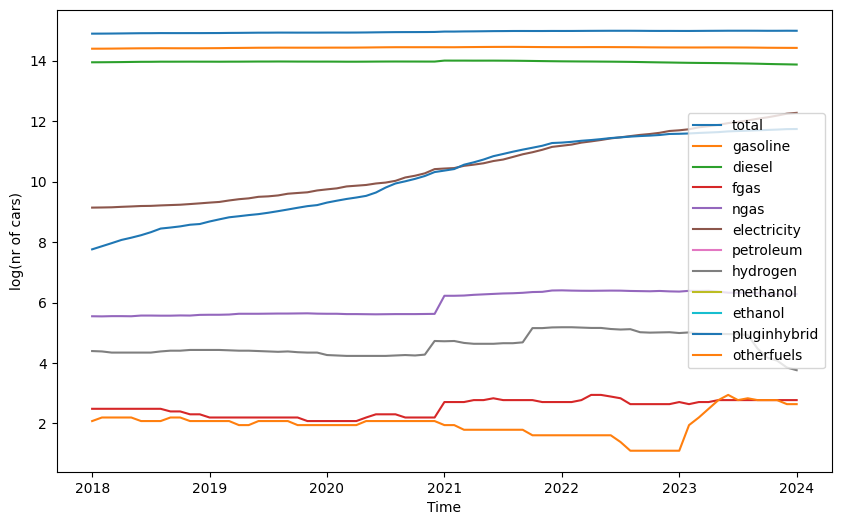

[2018.         2018.08333333 2018.16666667 2018.25       2018.33333333
 2018.41666667 2018.5        2018.58333333 2018.66666667 2018.75
 2018.83333333 2018.91666667 2019.         2019.08333333 2019.16666667
 2019.25       2019.33333333 2019.41666667 2019.5        2019.58333333
 2019.66666667 2019.75       2019.83333333 2019.91666667 2020.
 2020.08333333 2020.16666667 2020.25       2020.33333333 2020.41666667
 2020.5        2020.58333333 2020.66666667 2020.75       2020.83333333
 2020.91666667 2021.         2021.08333333 2021.16666667 2021.25
 2021.33333333 2021.41666667 2021.5        2021.58333333 2021.66666667
 2021.75       2021.83333333 2021.91666667 2022.         2022.08333333
 2022.16666667 2022.25       2022.33333333 2022.41666667 2022.5
 2022.58333333 2022.66666667 2022.75       2022.83333333 2022.91666667
 2023.         2023.08333333 2023.16666667 2023.25       2023.33333333
 2023.41666667 2023.5        2023.58333333 2023.66666667 2023.75
 2023.83333333 2023.91666667 2024.     

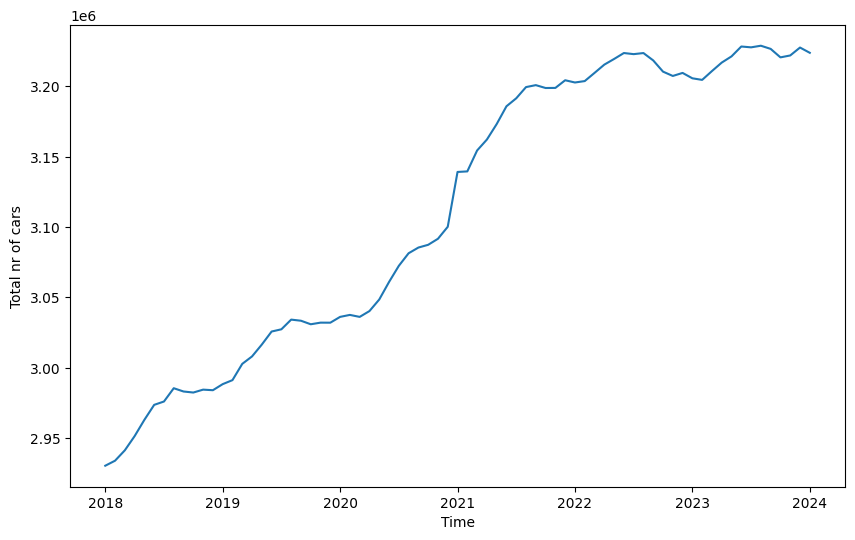

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

df = pd.read_csv('DST_BIL54.csv')

n = len(df)

labels = df.columns[1:]

time = np.arange(2018, 2018+n/12, 1/12)

df['time'] = time

#split into test and train
train = df[df['time'] < 2024]
test = df[df['time'] >= 2024]


plt.figure(figsize=(10, 6))
#plot the data
for label in labels:
    plt.plot(train['time'], np.log(train[label]), label=label)
plt.xlabel('Time')
plt.ylabel('log(nr of cars)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train['time'], train['total'])
plt.xlabel('Time')
plt.ylabel('Total nr of cars')


print(time)

## 2 Linear trend model

### 2.1

$Y = \theta \cdot X + \epsilon$

$ \begin{bmatrix}
2930483 \\
2934044 \\
2941422 
\end{bmatrix} = \begin{bmatrix}
1 & 2018 \\
1 & 2018.083 \\
1 & 2018.166 
\end{bmatrix} \cdot \begin{bmatrix}
\theta _1 \\
\theta _2 
\end{bmatrix} + \epsilon$


### 2.2, 2.3 and 2.4

Theta_0:  -108811321.71761814
Theta_0 standard error:  3607194.0685370415
Theta_1:  55380.136616120675
Theta_1 standard error:  1784.8553720966609
           Time  Total prediction  Total actual
0   2024.083333           3282689       3223805
1   2024.166667           3287304       3231177
2   2024.250000           3291919       3237629
3   2024.333333           3296534       3244611
4   2024.416667           3301149       3255073
5   2024.500000           3305764       3254569
6   2024.583333           3310379       3258060
7   2024.666667           3314994       3256515
8   2024.750000           3319609       3252275
9   2024.833333           3324224       3253059
10  2024.916667           3328839       3258025


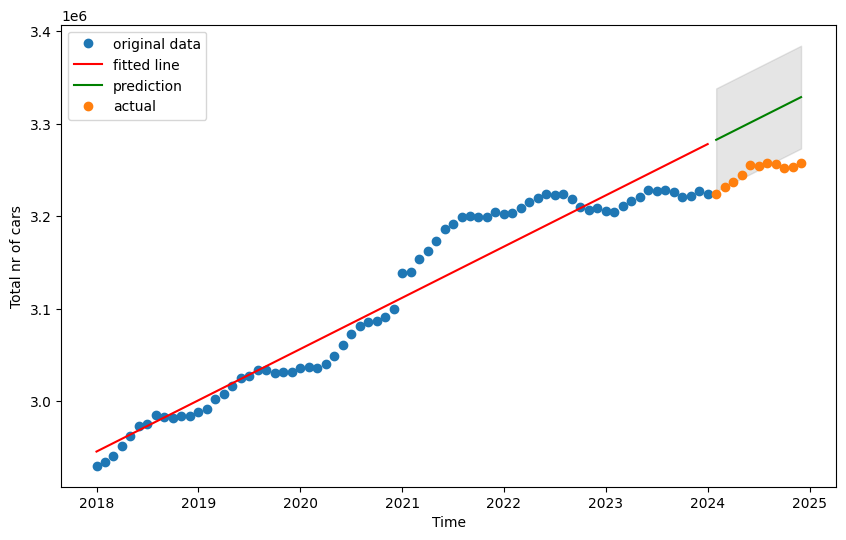

In [14]:
# estimate the trend

N = len(train)

x = np.array([np.ones(N),np.array(train['time'])]).T
y = np.array(train['total'])

x_future = np.array([np.ones(len(test)),np.array(test['time'])]).T
y_future = np.array(test['total'])


reg = LinearRegression(fit_intercept=False)
reg.fit(x, y)
#sigma_hat^2
var = sum((y - reg.predict(x))**2)/(N-2)
theta_var = np.linalg.inv(x.T@x)*var
standard_error = np.sqrt(np.diag(theta_var))

print("Theta_0: ", reg.coef_[0])
print("Theta_0 standard error: ", standard_error[0])
print("Theta_1: ", reg.coef_[1])
print("Theta_1 standard error: ", standard_error[1])


alpha = 0.05
dof = N-2
t_val = stats.t.isf(alpha/2, dof)

prediction_interval = []

for x_next in x_future:
    err_var = var + x_next.T @ theta_var @ x_next
    confidence = t_val*np.sqrt(err_var)
    prediction_interval.append(err_var)

prediction_interval = np.array(prediction_interval)



plt.figure(figsize=(10, 6))
plt.plot(x[:,1], y, 'o', label='original data')
plt.plot(x[:,1], (x@reg.coef_.T), 'r', label='fitted line')


prediction = x_future@reg.coef_.T
plt.plot(x_future[:,1], prediction, 'g', label='prediction')
plt.plot(x_future[:,1], y_future, 'o', label='actual')
plt.fill_between(x_future[:,1], prediction-confidence, prediction+confidence, color='gray', alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Total nr of cars')
plt.legend()

df = pd.DataFrame(x_future[:,1], columns=["Time"])
df['Total prediction'] = np.array(prediction, dtype=int)
df['Total actual'] = np.array(y_future, dtype=int)

print(df)




### 2.5

### 2.6

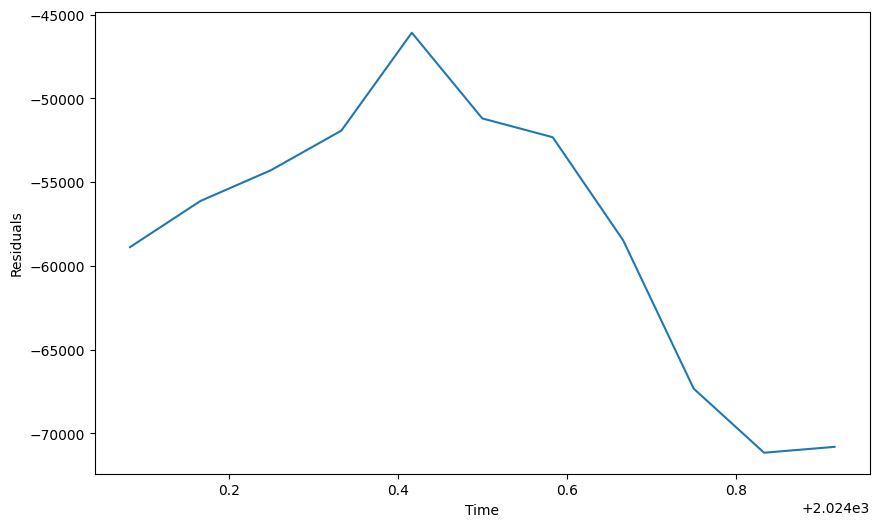

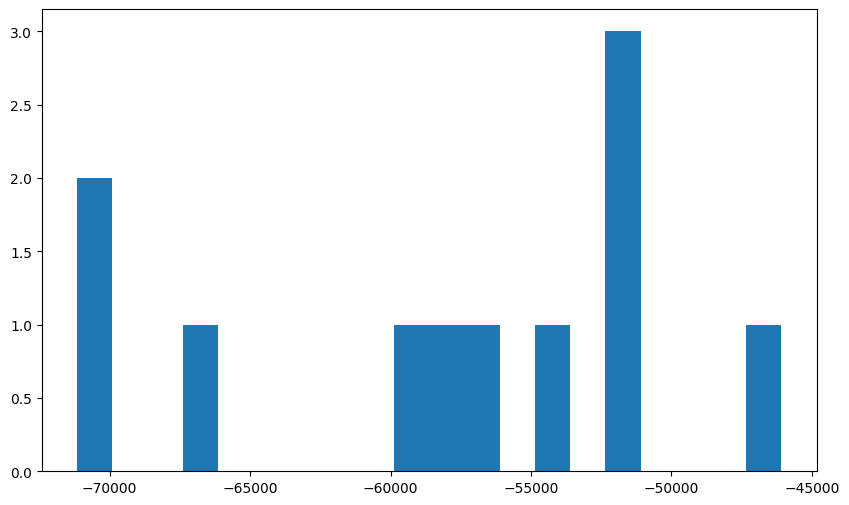

In [15]:
residuals = y_future - prediction
plt.figure(figsize=(10, 6))
# as bars
plt.plot(x_future[:,1], residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.show()

#histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.show()



# Recursive estimation

### Parameter Updates in Recursive Least Squares

At each time step \( t \), the parameter estimate \( \theta \) and the inverse covariance matrix \( R \) are updated as follows:

#### **Kalman Gain Calculation**
\[
K_t = R x_t \left( 1 + x_t^T R x_t \right)^{-1}
\]

#### **Update Parameter Estimate \( \theta \)**
\[
\theta_{\text{hat}} \leftarrow \theta_{\text{hat}} + K_t \left( y_t - x_t^T \theta_{\text{hat}} \right)
\]

#### **Update Inverse Covariance Matrix \( R \)**
\[
R \leftarrow R - K_t x_t^T R
\]

where:
- \( x_t \) is the feature vector at time \( t \).
- \( y_t \) is the observed output at time \( t \).
- \( \theta_{\text{hat}} \) is the estimated parameter vector.
- \( R \) is the inverse covariance matrix.
- \( K_t \) is the Kalman gain, which determines how much the estimate is adjusted based on the new observation.


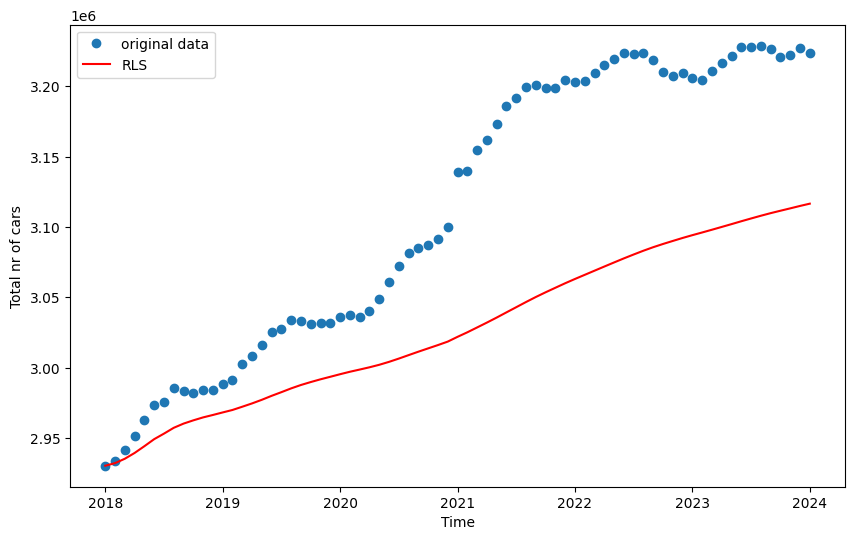

In [30]:
T = len(x)

y_results = []

# theta_hat = np.zeros((2,1))
theta_hat = np.array([[0],[0]])
R = np.eye(2)*0.1

y_pred = []

for t in range(T):
    x_t = x[t].reshape(-1, 1)  # Feature vector at time t
    y_t = y[t]  # Output at time t
    
    # Kalman gain: K_t = R * x_t / (lambda + x_t.T * R * x_t)
    K_t = R @ x_t / (1 + x_t.T @ R @ x_t)
    
    # Update theta_hat (parameter estimate)
    theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)
    
    # Update the inverse of covariance matrix (R)
    R = (R - K_t @ x_t.T @ R)
    
    # Predict output for time t
    y_pred.append((x_t.T @ theta_hat).item())
y_results.append(y_pred)

warmup_period = 0

plt.figure(figsize=(10, 6))
plt.plot(train['time'], y, 'o', label='original data')
plt.plot(train['time'][warmup_period:], y_results[0][warmup_period:], 'r', label='RLS')
plt.xlabel('Time')
plt.ylabel('Total nr of cars')
plt.legend()

plt.show()

In [29]:
theta_hat


theta_ols = np.linalg.inv(x.T @ x) @ x.T @ y

print("OLS: ", theta_ols)
print("RLS: ", theta_hat)

OLS:  [-1.08811322e+08  5.53801365e+04]
RLS:  [[-5.68313050e+06]
 [ 4.35187666e+03]]


with 

R0 = np.eye()*0.1, the updates are very slow, inversely by setting R too large, the updates will become very erratic, and also lead to poor conversion

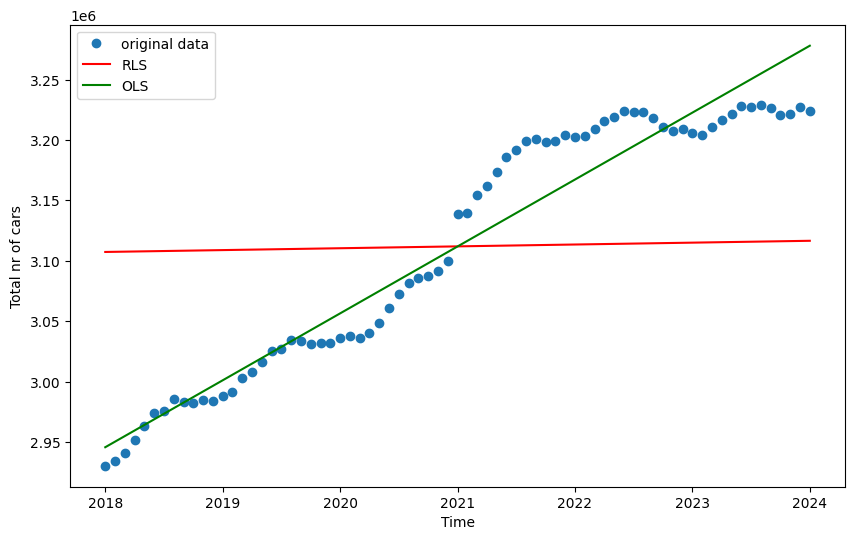

In [18]:
#plot theta ols
plt.figure(figsize=(10, 6))
plt.plot(x[:,1], y, 'o', label='original data')
plt.plot(x[:,1], (x@theta_hat), 'r', label='RLS')
plt.plot(x[:,1], (x@theta_ols), 'g', label='OLS')
plt.xlabel('Time')
plt.ylabel('Total nr of cars')
plt.legend()
plt.show()


**Forgetting** Lambda

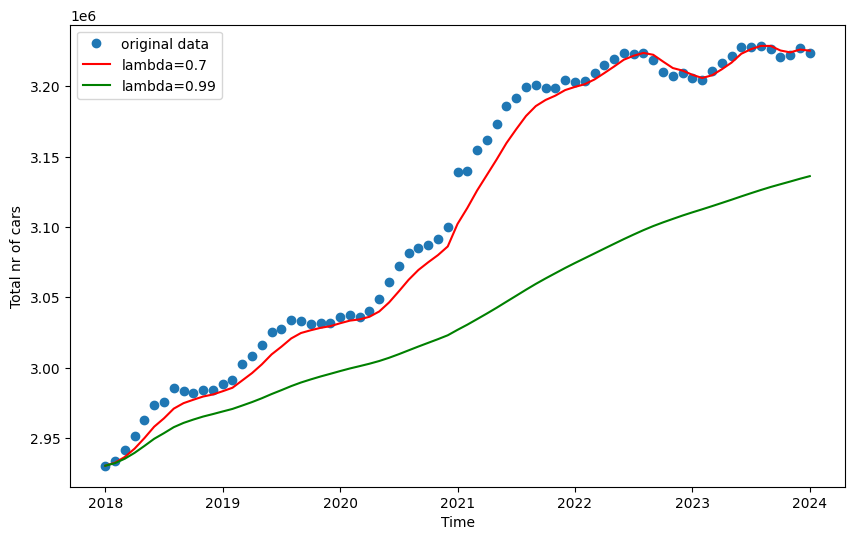

In [19]:
#write recursive least squares algorithm, for updating R_t and theta_t


T = len(train)

lambdas = [0.7, 0.99]

y_results = []

for lambda_ in lambdas:
    
    theta_hat = np.zeros((2,1))
    R = np.eye(2)*0.1

    y_pred = []
    
    for t in range(T):
        x_t = x[t].reshape(-1, 1)  # Feature vector at time t
        y_t = y[t]  # Output at time t
        
        # Kalman gain: K_t = R * x_t / (lambda + x_t.T * R * x_t)
        K_t = R @ x_t / (lambda_ + x_t.T @ R @ x_t)
        
        # Update theta_hat (parameter estimate)
        theta_hat = theta_hat + K_t * (y_t - x_t.T @ theta_hat)
        
        # Update the inverse of covariance matrix (R)
        R = (1 / lambda_) * (R - K_t @ x_t.T @ R)
        
        # Predict output for time t
        y_pred.append((x_t.T @ theta_hat).item())
    y_results.append(y_pred)
    

warmup_period = 0

plt.figure(figsize=(10, 6))
plt.plot(train['time'], y, 'o', label='original data')
plt.plot(train['time'][warmup_period:], y_results[0][warmup_period:], 'r', label='lambda=0.7')
plt.plot(train['time'][warmup_period:], y_results[1][warmup_period:], 'g', label='lambda=0.99')
plt.xlabel('Time')
plt.ylabel('Total nr of cars')
plt.legend()

plt.show()

# One step predictions

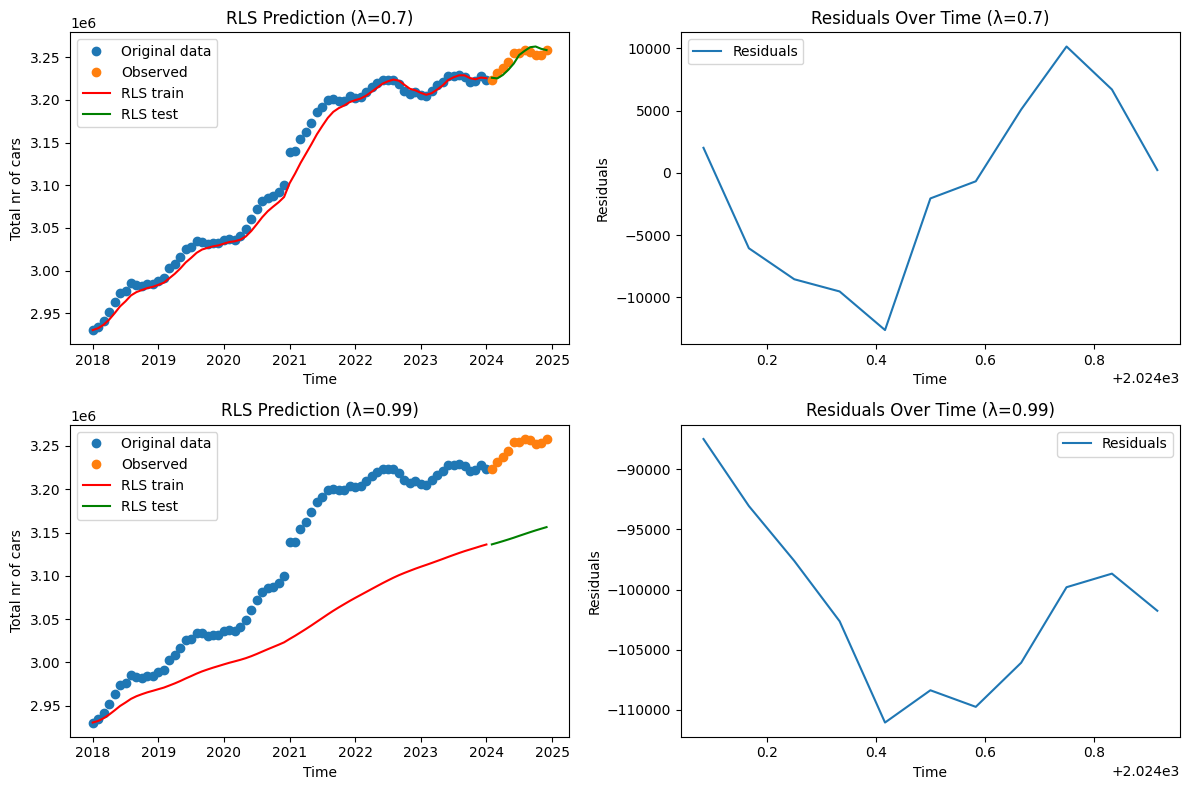

In [32]:
lambdas = [0.7, 0.99]

fig, axes = plt.subplots(len(lambdas), 2, figsize=(12, 8))  # 2 rows, 2 columns

for i, lambda_ in enumerate(lambdas):
    y_pred = []
    theta_hat = np.zeros((2, 1))  # Initialize parameter estimate
    R = np.eye(2) * 0.1  # Initialize inverse covariance matrix
    
    # --- Training Loop (RLS on Training Data) ---
    for t in range(T):
        x_t = x[t].reshape(-1, 1)  # Feature vector at time t
        y_t = y[t]  # Output at time t

        # Kalman gain: K_t = R * x_t / (lambda + x_t.T * R * x_t)
        K_t = R @ x_t / (lambda_ + x_t.T @ R @ x_t)

        # Update theta_hat (parameter estimate)
        theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)

        # Update the inverse of covariance matrix (R)
        R = (1 / lambda_) * (R - K_t @ x_t.T @ R)

        # Predict output for time t
        y_pred.append((x_t.T @ theta_hat).item())

    y_future_pred = []
    y_future_residuals = []

    # --- Closed-Loop Prediction (Adaptive RLS on Future Data) ---
    for j in range(len(x_future)):
        x_t = x_future[j].reshape(-1, 1)  # Feature vector at time t
        y_t = y_future[j]  # True output at time t

        # Predict output for time t
        y_pred_t = (x_t.T @ theta_hat).item()
        y_future_pred.append(y_pred_t)

        # Compute residuals
        residual = y_pred_t - y_t
        y_future_residuals.append(residual)

        # Update RLS with new observation (adaptive learning)
        K_t = R @ x_t / (lambda_ + x_t.T @ R @ x_t)
        theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)
        R = (1 / lambda_) * (R - K_t @ x_t.T @ R)

    # --- Subplot 1: Predictions ---
    axes[i, 0].plot(train['time'], y, 'o', label='Original data')
    axes[i, 0].plot(test['time'], y_future, 'o', label='Observed')
    axes[i, 0].plot(train['time'], y_pred, 'r', label='RLS train')
    axes[i, 0].plot(test['time'], y_future_pred, 'g', label='RLS test')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].set_ylabel('Total nr of cars')
    axes[i, 0].set_title(f'RLS Prediction (λ={lambda_})')
    axes[i, 0].legend()

    # --- Subplot 2: Residuals ---
    axes[i, 1].plot(test['time'], y_future_residuals, label='Residuals')
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('Residuals')
    axes[i, 1].set_title(f'Residuals Over Time (λ={lambda_})')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


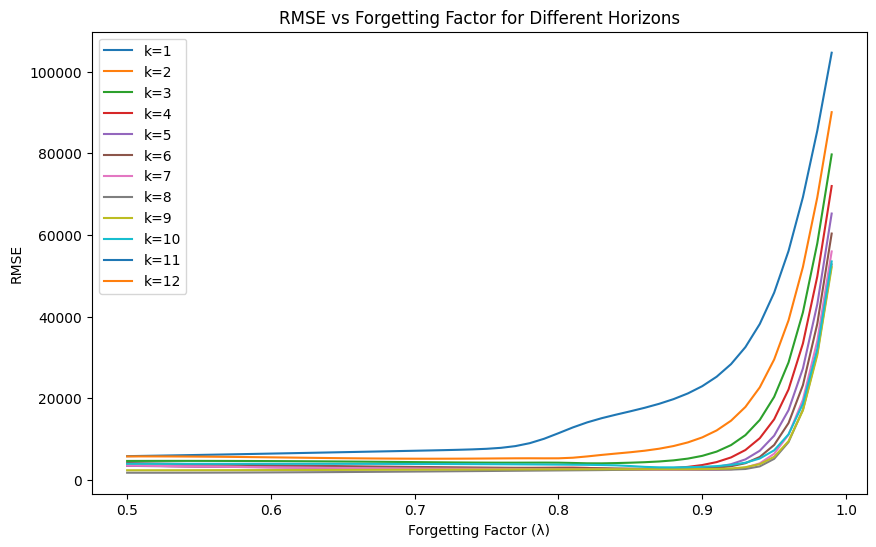

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define lambda values to test
lambda_values = np.arange(0.5, 1.0, 0.01)
horizons = np.arange(1, 13)  # k = 1 to 12

# Store RMSE results
rmse_results = np.zeros((len(horizons), len(lambda_values)))

for lambda_idx, lambda_ in enumerate(lambda_values):
    theta_hat = np.zeros((2, 1))  # Initialize parameters
    R = np.eye(2) * 0.1  # Initialize covariance
    
    # --- Train RLS on training data ---
    for t in range(T):
        x_t = x[t].reshape(-1, 1)
        y_t = y[t]

        # Compute Kalman gain
        K_t = R @ x_t / (lambda_ + x_t.T @ R @ x_t)
        
        # Update estimates
        theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)
        R = (1 / lambda_) * (R - K_t @ x_t.T @ R)

    # --- Evaluate RMSE for each horizon ---
    for k_idx, k in enumerate(horizons):
        residuals = []

        for t in range(len(x_future) - k):
            x_t = x_future[t].reshape(-1, 1)
            y_t = y_future[t + k]

            # Predict y_t+k given information at time t
            y_pred_t = (x_t.T @ theta_hat).item()
            residuals.append((y_pred_t - y_t) ** 2)

            # Online update
            K_t = R @ x_t / (lambda_ + x_t.T @ R @ x_t)
            theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)
            R = (1 / lambda_) * (R - K_t @ x_t.T @ R)

        # Compute RMSE_k for this lambda
        rmse_results[k_idx, lambda_idx] = np.sqrt(np.mean(residuals))

# --- Plot RMSE as a function of lambda ---
plt.figure(figsize=(10, 6))
for k_idx, k in enumerate(horizons):
    plt.plot(lambda_values, rmse_results[k_idx, :], label=f'k={k}')

plt.xlabel("Forgetting Factor (λ)")
plt.ylabel("RMSE")
plt.title("RMSE vs Forgetting Factor for Different Horizons")
plt.legend()
plt.show()


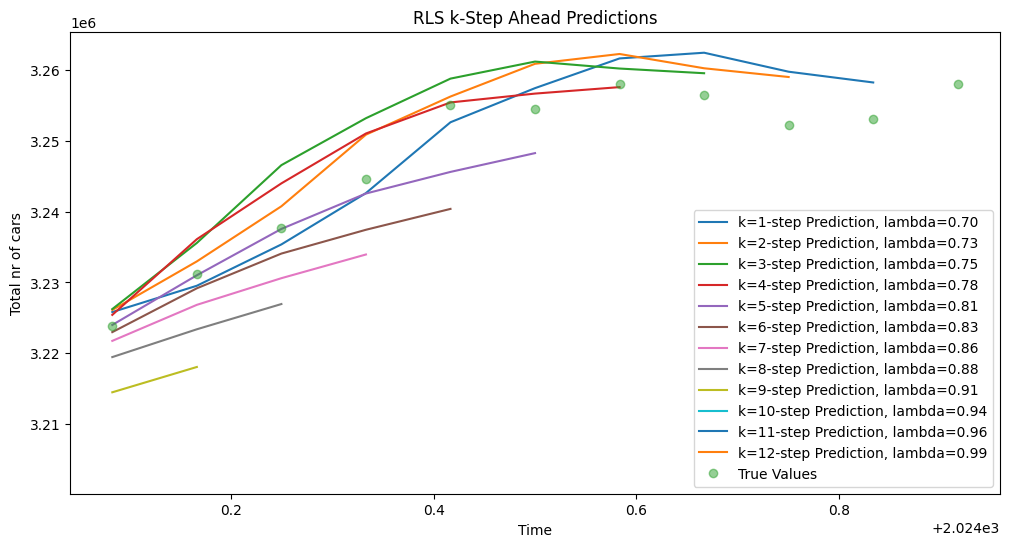

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Define lambda values (either fixed or adaptive)
fixed_lambda = 0.8  # Use a single lambda for all horizons
adaptive_lambda = np.linspace(0.7, 0.99, 12)  # Example: decrease forgetting for longer horizons

horizons = np.arange(1, 13)  # k = 1 to 12
test_predictions = {k: [] for k in horizons}  # Store predictions for each horizon
test_residuals = {k: [] for k in horizons}

for k_idx, k in enumerate(horizons):
    lambda_k = adaptive_lambda[k_idx]  # Use adaptive lambda
    # lambda_k = fixed_lambda  # Use fixed lambda
    theta_hat = np.zeros((2, 1))  # Initialize parameter estimates
    R = np.eye(2) * 0.1  # Initialize covariance matrix

    # Train RLS on the training data
    for t in range(T):
        x_t = x[t].reshape(-1, 1)
        y_t = y[t]

        # Compute Kalman gain
        K_t = R @ x_t / (lambda_k + x_t.T @ R @ x_t)

        # Update estimates
        theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)
        R = (1 / lambda_k) * (R - K_t @ x_t.T @ R)

    # Predict test set for k-step ahead
    for t in range(len(x_future) - k):
        x_t = x_future[t].reshape(-1, 1)
        y_t = y_future[t + k]  # True value at t+k

        # Predict y_t+k given info at time t
        y_pred_t = (x_t.T @ theta_hat).item()
        test_predictions[k].append(y_pred_t)
        test_residuals[k].append(y_pred_t - y_t)

        # Online update with new data
        K_t = R @ x_t / (lambda_k + x_t.T @ R @ x_t)
        theta_hat = theta_hat + K_t @ (y_t - x_t.T @ theta_hat)
        R = (1 / lambda_k) * (R - K_t @ x_t.T @ R)

# --- Plot k-step predictions ---
plt.figure(figsize=(12, 6))
for k in range(12):  # Select key horizons for visualization
    k+=1
    plt.plot(test['time'][:len(test_predictions[k])], test_predictions[k], label=f'k={k}-step Prediction, lambda={adaptive_lambda[k-1]:.2f}')

plt.plot(test['time'], y_future, 'o', label='True Values', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Total nr of cars')
plt.legend()
plt.title('RLS k-Step Ahead Predictions')
plt.show()
